In [1]:

# import gym
import gymnasium as gym
# from gym import spaces
from gymnasium import spaces
import pygame
import numpy as np
import random
from env.simulator import Simulator
import env.constants as constants
from torchrl.envs.utils import check_env_specs
# from gym.utils.env_checker import check_env
# from gym.envs.registration import register
from gymnasium.envs.registration import register
from tensordict import TensorDict
# import gym
from stable_baselines3 import PPO
from stable_baselines3.common.env_checker import check_env
import torch
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
class LISPredatorPreyEnv(gym.Env):
    def __init__(self):
        super(LISPredatorPreyEnv, self).__init__()
        
        # 初始化模拟器
        self.simulator = Simulator(screen_width=3840, screen_height=2160)
        self.group_map = {}
        self.current_step = 0
        self.max_steps = 10_000


        
        # 初始化观察和动作空间
        self.max_range = max(600, 1000)  
        self.zero_list = [[0 for _ in range(3)] for _ in range(25)]
        self.num_entities = constants.NUM_PREDATORS + constants.NUM_PREY
        self.new_shape = (self.num_entities, 25, 3)
        self.obs_low = np.full(self.new_shape, -self.max_range, dtype=np.float32) #inf maybe not the best choice , let us decide later
        self.obs_high = np.full(self.new_shape, self.max_range, dtype=np.float32)
        self.action_shape = (self.num_entities,3)
        self.action_speed_range = max(constants.PREY_MAX_SPEED,constants.PREY_MAX_SPEED)
        self.action_low = np.full(self.action_shape, -self.action_speed_range, dtype=np.float32)
        self.action_high = np.full(self.action_shape, self.action_speed_range, dtype=np.float32)
        self.action_low[:, 0] = 0.0   # 将第一列的低值设为0
        self.action_high[:, 0] = 1.0  # 将第一列的高值设为1
        # obs_low = np.array([0, 0, 0] * 25*(constants.NUM_PREDATORS+constants.NUM_PREY))
        # obs_high = np.array([max_range, max_range, max_range] * 25*(constants.NUM_PREDATORS+constants.NUM_PREY))
        # self.observation_space_shape = (constants.NUM_PREDATORS+constants.NUM_PREY) * 3 * 25
        self.observation_space = spaces.Box(low=self.obs_low, high=self.obs_high,dtype=np.float32)

        self.action_space = spaces.Box(low=self.action_low, high=self.action_high, dtype=np.float32)

        self.interation = 0
        self.initialnames = []
        self.prey_algorithms = []
        self.pred_algorithms = []

        # self.initialdicts = {}
        # 调用 reset 方法初始化环境
        # self.reset() 

    # def reset(self):
    #     # 重置模拟器
    #     all_pred_algorithms,all_prey_algorithms = self.reset_algorithm()
    #     self.simulator.initialize(all_pred_algorithms,all_prey_algorithms)
    #     self.map_agents_to_groups(self.simulator.predators,self.simulator.preys)
    #     # 初始化环境信息（捕食者、猎物、食物和障碍物）
    #     for predator in self.simulator.predators:
    #         self._set_agent_env(predator)
    #     for prey in self.simulator.preys:
    #         self._set_agent_env(prey)
    #     # 获取所有智能体的初始观测数据
    #     observations = {}
    #     for group_name in self.group_map.keys():
    #         observations[group_name] = []
    #         for agent in getattr(self.simulator, group_name):
    #             observations[group_name].append(agent.get_observe_info())
    #     info  = {}

    #     # 返回包含所有智能体观测数据的字典
    #     return observations,info
        
    def reset(self, seed=None, **kwargs):
        # 重置模拟器
        super().reset(seed=seed, **kwargs)
        self.initialnames = []
        self.group_map.clear()
        if seed is not None:
            np.random.seed(seed)
            random.seed(seed)
        allalgorithms= self.reset_algorithm()
        all_pred_algorithms, all_prey_algorithms = allalgorithms[:constants.NUM_PREDATORS],allalgorithms[constants.NUM_PREDATORS:]
        self.simulator.initialize(all_pred_algorithms, all_prey_algorithms)
        for agent in self.simulator.preys +self.simulator.predators:

            self.initialnames.append(agent.name)
        self.map_agents_to_groups(self.simulator.predators, self.simulator.preys)
        # 初始化环境信息（捕食者、猎物、食物和障碍物）
        for predator in self.simulator.predators:
            self._set_agent_env(predator)
        for prey in self.simulator.preys:
            self._set_agent_env(prey)
        # 获取所有智能体的初始观测数据
        all_observations = []
        for group_name in self.group_map.keys():
            for agent in getattr(self.simulator, group_name):
                all_observations.append(agent.get_observe_info())
        
        obs = np.array(all_observations, dtype=np.float32) #np.shape(all_observations) = (2250,3)
        # print(np.shape(all_observations))
        # obs = TensorDict({
        #     'observation': torch.tensor(obs)
        # }, batch_size=[])
        info = {}
        # print("Initial Observation:", obs)
        # assert self.observation_space.contains(obs), "Initial observation is out of bounds!"

        # 返回一个数组，符合 observation_space 的定义
        return obs,info

    def map_agents_to_groups(self,simPredators,simPreys):
        self.group_map['predators'] = [predator.name for predator in simPredators]
        self.group_map['preys'] = [prey.name for prey in simPreys]

    def reset_algorithm(self):
        # prey_algorithms = ["PPO","PPO","PPO","DDPG","DDPG","DDPG"]
        # pred_algorithms = ["PPO","PPO","PPO","DDPG","DDPG","DDPG"]
        all_pred_algorithms = assign_algorithms_to_agents(constants.NUM_PREDATORS,self.pred_algorithms)
        all_prey_algorithms = assign_algorithms_to_agents(constants.NUM_PREY,self.prey_algorithms)
        return all_pred_algorithms+all_prey_algorithms
        # assigned_Predalgorithms = assign_algorithms_to_agents(self.simulator.predators, all_pred_algorithms)
        # assigned_Preyalgorithms = assign_algorithms_to_agents(self.simulator.preys, all_prey_algorithms)

    def _set_agent_env(self, agent):
        agent.env_predators = self.simulator.predators
        agent.env_prey = self.simulator.preys
        agent.env_food = self.simulator.foods
        agent.env_obstacles = self.simulator.obstacles

    # def step(self, actions):
    #     new_state, rewards, dones, infos = {}, {}, {}, {}
    #     statesList,rewardsList,donesList,infosList = [],[],[],[]
    #     self.current_step += 1
    #     truncated = self.current_step >= self.max_steps
    #     # self.simulator.check_events()

        
    #     # self.simulator.move_models()

    #     # 独立处理每个组的动作
    #     for group_name in self.group_map.keys():
    #         group_actions = actions[group_name]
    #         new_state[group_name], rewards[group_name], dones[group_name], infos[group_name] = self._step_group(group_name, group_actions)
    #     self.simulator.add_food()  # 传递时间间隔
    #     self.simulator.prey_hunt()
    #     self.simulator.check_collisions()

    #     # self.simulator.predator_hunt()
    #     self.simulator.decrease_health()  # 更新健康值
    #     self.simulator.remove_dead()  # 清理死亡个体
    #     # self.simulator.draw_models(screen)

    #     # sim.check_events()

        
    #     # sim.move_models()
    #     # sim.add_food()  # 传递时间间隔
    #     # sim.prey_hunt()
    #     # sim.check_collisions()
    #     # # sim.predator_hunt()
    #     # # new_prey_born, new_predator_born = sim.applyGeneticAlgorithm()
    #     # sim.decrease_health()  # 更新健康值
    #     # sim.remove_dead()  # 清理死亡个体
    #     # iteration_count += 1  # 增加迭代计数器
    #     # sim.draw_models(screen)

    #     # new_prey_born, new_predator_born = self.simulator.applyGeneticAlgorithm()

    #     return new_state, rewards, dones, truncated, infos
    def step(self, actions):
        new_state, rewards, dones, infos = [], [], [], []
        initialdicts = dict(zip(self.initialnames, actions))
        self.simulator.add_food()  # 传递时间间隔
        self.simulator.move_models(actions =initialdicts)

        self.simulator.prey_hunt()
        self.simulator.check_collisions(initialdicts)
        self.simulator.decrease_health()  # 更新健康值
        self.simulator.remove_dead()  # 清理死亡个体

        self.current_step += 1
        truncated = self.current_step >= self.max_steps
        for name in self.initialnames:
            # 查找 B 列表中是否有 agent 的名字和 A 列表中的名字匹配
            matching_agent = next((agent for agent in self.simulator.preys+self.simulator.predators if agent.name == name), None)
            
            if matching_agent and matching_agent.is_alive == True:
                # 如果在 B 列表中找到匹配的 agent，获取其状态和奖励信息
                new_state.append(matching_agent.get_observe_info())
                rewards.append(self._compute_reward(matching_agent))  # 或者根据需要计算奖励
                dones.append(False)
                infos.append({})

            else:
                # 如果未找到匹配的 agent，说明该 agent 已死亡
                new_state.append(np.zeros((25, 3)))
                rewards.append(0)
                dones.append(True)
                infos.append({})


        # 获取所有键并转换为列表
        # keys = list(self.simulator.agent_status.keys())

        # # 获取从 constants.NUM_PREDATORS 开始往后 constants.NUM_PREYS 个键
        # selected_keys = keys[constants.NUM_PREDATORS:constants.NUM_PREDATORS + constants.NUM_PREY]

        # # 构建新的字典

        # # all_actions =[]
        # # all_pred_actions, all_prey_actions = actions[:constants.NUM_PREDATORS],actions[constants.NUM_PREDATORS:]
        # # 独立处理每个组的动作
        # for group_name in self.group_map.keys():
        #     if group_name == "predators":
        #         group_actions = actions[:constants.NUM_PREDATORS]
        #         agent_status = {k: self.simulator.agent_status[k] for k in list(self.simulator.agent_status.keys())[:constants.NUM_PREDATORS]}
        #     if group_name == "preys":
        #         group_actions = actions[constants.NUM_PREDATORS:]
        #         agent_status = {k: self.simulator.agent_status[k] for k in selected_keys}
            
        #     # 获取每个组的数据，并将其展开添加到主列表中
        #     group_states, group_rewards, group_dones, group_infos = self._step_group(group_name, group_actions,agent_status)
        #     new_state.extend(group_states)
        #     rewards.extend(group_rewards)
        #     dones.extend(group_dones)
        #     infos.extend(group_infos)
        # infos = {
        #     f"info_{i}": info_item for i, info_item in enumerate(infos)
        # }
        terminated = all(dones)   
        # # 将 observations 列表转换为 numpy 数组
        # new_observations = np.array(new_state, dtype=np.float32)
        # # 调用模拟器的其他方法
        # self.simulator.move_models()
        # self.simulator.add_food()  # 传递时间间隔
        # self.simulator.prey_hunt()
        # self.simulator.check_collisions()
        # self.simulator.decrease_health()  # 更新健康值
        # self.simulator.remove_dead()  # 清理死亡个体

        return np.array(new_state,dtype=np.float32), sum(rewards), terminated, truncated,{}


    # def _step_group(self, group_name, group_actions):
    #     # 执行每个组的动作，并获取新的状态、奖励、是否完成和信息
    #     new_observations = []
    #     rewards = []
    #     dones = []
    #     infos = []
    #     # print(np.shape(group_actions))
    #     group = getattr(self.simulator, group_name)
    #     for agent, action in zip(group, group_actions):
    #         agent.move_strategy(action)
    #         agent.move(constants.CONTROL_PANEL_WIDTH, self.simulator.screen_width, self.simulator.screen_height, self.simulator.obstacles)
            
    #         new_observations.append(agent.get_observe_info())
    #         rewards.append(self._compute_reward(agent, group_name))
    #         dones.append(not agent.is_alive)  # 这里假设死亡标志环境结束
    #         infos.append({})  # 可以添加更多的调试信息

    #     return new_observations, rewards, dones, infos
    # def _step_group(self, group_name, group_actions):
    #     # 执行每个组的动作，并获取新的状态、奖励、是否完成和信息
    #     new_observations = []
    #     rewards = []
    #     dones = []
    #     infos = []
        
    #     group = getattr(self.simulator, group_name)
    #     for agent, action in zip(group, group_actions):
    #         agent.move_strategy(action)
    #         agent.move(constants.CONTROL_PANEL_WIDTH, self.simulator.screen_width, self.simulator.screen_height, self.simulator.obstacles)
            
    #         new_observations.append(agent.get_observe_info())
    #         rewards.append(self._compute_reward(agent, group_name))
    #         dones.append(not agent.is_alive)  # 这里假设死亡标志环境结束
    #         infos.append({})  # 可以添加更多的调试信息

    #     return new_observations, rewards, dones, infos
    # def _step_group(self, group_name, group_actions, agent_status):
    #     # 执行每个组的动作，并获取新的状态、奖励、是否完成和信息
    #     temp_observations = {}
    #     temp_rewards = {}
    #     temp_dones = {}
    #     temp_infos = {}

    #     group = getattr(self.simulator, group_name)
        
    #     # for agent, action in zip(group, group_actions):
    #     #     agent.move_strategy(action)
    #     #     agent.move(constants.CONTROL_PANEL_WIDTH, self.simulator.screen_width, self.simulator.screen_height, self.simulator.obstacles)
            
    #     #     temp_observations[agent.name] = agent.get_observe_info()
    #     #     temp_rewards[agent.name] = self._compute_reward(agent, group_name)
    #     #     temp_dones[agent.name] = not agent.is_alive  # 这里假设死亡标志环境结束
    #     #     temp_infos[agent.name] = {}  # 可以添加更多的调试信息
    #     for i, agent in enumerate(group):
    #         if i < len(group_actions):
    #             action = group_actions[i]
    #         else:
    #             # 如果没有提供动作，根据 agent 的属性选择算法
    #             # if hasattr(agent, 'algorithm') and agent.algorithm in self.available_algorithms:
    #             #     action = self.available_algorithms[agent.algorithm](agent)  # 使用特定算法生成动作
    #             # else:
    #             #     action = self.random_action(agent)  # 使用随机动作
    #             action = self.action_space.sample()[0] # this need to change to differience algorithm

    #         # 之后执行相应的动作
    #         agent.move_strategy(action)
    #         agent.move(constants.CONTROL_PANEL_WIDTH, self.simulator.screen_width, self.simulator.screen_height, self.simulator.obstacles)

    #         # 继续获取状态、奖励、done 和 info
    #         temp_observations[agent.name] = agent.get_observe_info()
    #         temp_rewards[agent.name] = self._compute_reward(agent, group_name)
    #         temp_dones[agent.name] = not agent.is_alive  # 这里假设死亡标志环境结束
    #         temp_infos[agent.name] = {}  # 可以添加更多的调试信息



    #     # 根据 agent_status 比对结果，生成最终的列表
    #     new_observations = []
    #     rewards = []
    #     dones = []
    #     infos = []
        
    #     for agent_name in agent_status.keys():
    #         if agent_name in temp_observations:
    #             new_observations.append(temp_observations[agent_name])
    #             rewards.append(temp_rewards[agent_name])
    #             dones.append(temp_dones[agent_name])
    #             infos.append(temp_infos[agent_name])
    #         else:
    #             new_observations.append(np.array(self.zero_list))  # 如果 agent 不存在，则返回0
    #             rewards.append(0)  # 如果 agent 不存在，则返回0
    #             dones.append(True)  # 如果 agent 不存在，则认为它完成了
    #             infos.append({})  # 如果 agent 不存在，则返回空信息字典

    #     return new_observations, rewards, dones, infos


    # def random_action(self, max_speed):
    #     # 生成随机方向的速度
    #     angle = np.random.uniform(0, 2 * np.pi)  # 在0到2π之间生成随机角度
    #     speed = np.random.uniform(0, max_speed)  # 在0到max_speed之间生成随机速度大小
        
    #     # 根据角度和速度计算x和y分量
    #     velocity_x = speed * np.cos(angle)
    #     velocity_y = speed * np.sin(angle)
        
    #     # 返回速度向量
    #     return np.array([velocity_x, velocity_y], dtype=np.float32)
    

    def _compute_reward(self, agent):
        # 根据组别计算奖励
        if agent.type == 'predator':
            # 捕食者奖励
            return agent.health if agent.health > 0 else -1.0
        elif agent.type == 'prey':
            # 猎物奖励
            return agent.health if agent.health > 0 else -1.0
        return 0

    def render(self, mode='human'):
        # Initialize Pygame screen if not already initialized
        if not hasattr(self, 'screen'):
            pygame.init()
            if mode == 'human':
                self.screen = pygame.display.set_mode((self.simulator.screen_width, self.simulator.screen_height))
            elif mode == 'rgb_array':
                self.screen = pygame.Surface((self.simulator.screen_width, self.simulator.screen_height))

        # Fill the background with black color
        self.screen.fill((0, 0, 0))
        # print(self.simulator.predators)
        # Draw models onto the screen
        self.simulator.draw_models(self.screen)

        # Update the display if mode is 'human'
        if mode == 'human':
            pygame.display.flip()
        elif mode == 'rgb_array':
            return self._get_rgb_array()

    def _get_rgb_array(self):
        # Convert Pygame surface to an RGB array (numpy)
        return np.transpose(
            np.array(pygame.surfarray.pixels3d(self.screen)),
            axes=(1, 0, 2)
        )

    def close(self):
        # 关闭环境
        pass





In [3]:
def generate_random_actions(num_agents, action_space):
    actions = []
    for _ in range(num_agents):
        action = action_space.sample()  # 从动作空间中采样一个随机动作
        # print(action)
        actions.append(action)
    return actions









def assign_algorithms_to_agents(len_agents, algorithm_names):
    """
    分配算法给每个智能体。

    参数:
    - agents: 智能体列表。
    - algorithm_names: 预定义的算法名称列表。

    返回:
    - 包含算法名称的列表，长度与agents列表相同。如果算法名称不足，则用'random'补充。
    """
    assigned_algorithms = []
    for i in range(len_agents):
        if i < len(algorithm_names):
            assigned_algorithms.append(algorithm_names[i])
        else:
            assigned_algorithms.append('random')
    return assigned_algorithms
def apply_algorithms_to_agents(agents, algorithms):
    """
    将算法分配给每个智能体。

    参数:
    - agents: 智能体列表。
    - algorithms: 已分配的算法名称列表。
    """
    for agent, algorithm in zip(agents, algorithms):
        agent.algorithm = algorithm  # 将算法分配给智能体

import matplotlib.pyplot as plt

def update_and_plot(iteration, env, data_storage):
    # Count the number of predators, prey, and food
    predator_count = len(env.simulator.predators)
    prey_count = len(env.simulator.preys)
    food_count = len(env.simulator.foods)

    # Calculate total healths
    predator_total_health = sum(predator.health for predator in env.simulator.predators)
    prey_total_health = sum(prey.health for prey in env.simulator.preys)
    food_total_health = (len(env.simulator.foods) * constants.FOOD_HEALTH_GAIN)
    total_energy = predator_total_health+prey_total_health+food_total_health

    # Store the current values
    data_storage['iterations'].append(iteration)
    data_storage['predator_counts'].append(predator_count)
    data_storage['prey_counts'].append(prey_count)
    data_storage['total_counts'].append(predator_count+prey_count)
    data_storage['predator_healths'].append(predator_total_health)
    data_storage['prey_healths'].append(prey_total_health)
    data_storage['total_healths'].append(total_energy)

    # Update plots
    plt.clf()

    # Plot counts
    plt.subplot(2, 1, 1)
    plt.plot(data_storage['iterations'], data_storage['predator_counts'], label='Predator Count')
    plt.plot(data_storage['iterations'], data_storage['prey_counts'], label='Prey Count')
    plt.plot(data_storage['iterations'], data_storage['total_counts'], label='total Count')
    plt.xlabel('Iteration')
    plt.ylabel('Count')
    plt.title('Number of Predators, Prey, and total Over Time')
    plt.legend()

    # Plot healths
    plt.subplot(2, 1, 2)
    plt.plot(data_storage['iterations'], data_storage['predator_healths'], label='Predator Total Health')
    plt.plot(data_storage['iterations'], data_storage['prey_healths'], label='Prey Total Health')
    plt.plot(data_storage['iterations'], data_storage['total_healths'], label=' Total Health')
    plt.xlabel('Iteration')
    plt.ylabel('Total Health')
    plt.title('')
    plt.legend()

    plt.pause(0.01)  # Pause to update the plot in real-time



def run_random_simulation(env):
    
    # env = PredatorPreyEnv()
    observations,infos = env.reset()
    obs = observations
    # print("Returned Observation:", obs)
    # print("Observation Space Low:", env.observation_space.low)
    # print("Observation Space High:", env.observation_space.high)
    # print("Observation dtype:", obs.dtype)
    # print("Expected dtype:", env.observation_space.dtype)
    # assert env.observation_space.contains(obs), "Observation is out of bounds!"

    # print(np.shape(observations),end="---")
    # print(np.shape(env.observation_space))
    # check_env_specs(env)

    # check_env(env)
    # rollout = env.rollout(10)
    # print(f"rollout of {10} steps:", rollout)
    # print("Shape of the rollout TensorDict:", rollout.batch_size)
    

    # observations = env.reset()
    #print(np.shape(observation))
    # Initialize lists to store the values for each iteration

    # Initialize a dictionary to store the data
    data_storage = {
        'iterations': [],
        'predator_counts': [],
        'prey_counts': [],
        'total_counts': [],
        'predator_healths': [],
        'prey_healths': [],
        'total_healths': []
    }

    # Initialize the plot
    plt.figure(figsize=(10, 8))
    plt.ion()  # Enable interactive mode
    done = False
    iteration = 0

    while not done:
        

        # actions = {
        #     'predators': generate_random_actions(len(env.simulator.predators), env.action_space),
        #     'preys': generate_random_actions(len(env.simulator.preys), env.action_space),
        # }
        update_and_plot(iteration, env, data_storage)

        actions = env.action_space.sample()  # 从动作空间中采样一个随机动作 # you can change this with your algorithm
        new_state, rewards, done,truncated, infos = env.step(actions)

        # 判断是否所有智能体都已经完成
        # done = all(all(done_group) for done_group in dones.values())
        iteration +=1

        # 渲染环境（可选）
        env.render()
        if iteration % 100 == 1:   
            pass
            # print(f"iteration: {iteration}, num_predators: {len(env.simulator.predators)}, num_preys: {len(env.simulator.preys)}")

            # print(iteration,end="\t")
            print(len(env.simulator.predators),end="\t")
            print(len(env.simulator.preys))
        # 打印当前状态、奖励、是否结束
            # print(f"New State: {new_state}")
            # print(f"Rewards: {new_state}")
            # print(len(new_state))
            # print(f"Dones: {np.shape(done)}")
            # print(f"Dones length:{len(done)}")
            # print(f"Infos: {infos}")
    plt.ioff()  # Disable interactive mode
    plt.show()  # Keep the final plot open after the loop ends



/home/qrbao/anaconda3/envs/LISPREY/lib/python3.9/site-packages/stable_baselines3/common/env_checker.py:30: UserWarning: It seems that your observation  is an image but its `dtype` is (float32) whereas it has to be `np.uint8`. If your observation is not an image, we recommend you to flatten the observation to have only a 1D vector
  warnings.warn(
/home/qrbao/anaconda3/envs/LISPREY/lib/python3.9/site-packages/stable_baselines3/common/env_checker.py:38: UserWarning: It seems that your observation space  is an image but the upper and lower bounds are not in [0, 255]. Because the CNN policy normalize automatically the observation you may encounter issue if the values are not in that range.
  warnings.warn(
/home/qrbao/anaconda3/envs/LISPREY/lib/python3.9/site-packages/stable_baselines3/common/env_checker.py:51: UserWarning: The minimal resolution for an image is 36x36 for the default `CnnPolicy`. You might need to use a custom features extractor cf. https://stable-baselines3.readthedocs.io

Observation: <class 'numpy.ndarray'>, Reward: (), Done: (), Info: ()
Observation: <class 'numpy.ndarray'>, Reward: (), Done: (), Info: ()
Observation: <class 'numpy.ndarray'>, Reward: (), Done: (), Info: ()
Observation: <class 'numpy.ndarray'>, Reward: (), Done: (), Info: ()
Observation: <class 'numpy.ndarray'>, Reward: (), Done: (), Info: ()
Observation: <class 'numpy.ndarray'>, Reward: (), Done: (), Info: ()
Observation: <class 'numpy.ndarray'>, Reward: (), Done: (), Info: ()
Observation: <class 'numpy.ndarray'>, Reward: (), Done: (), Info: ()
Observation: <class 'numpy.ndarray'>, Reward: (), Done: (), Info: ()
Observation: <class 'numpy.ndarray'>, Reward: (), Done: (), Info: ()


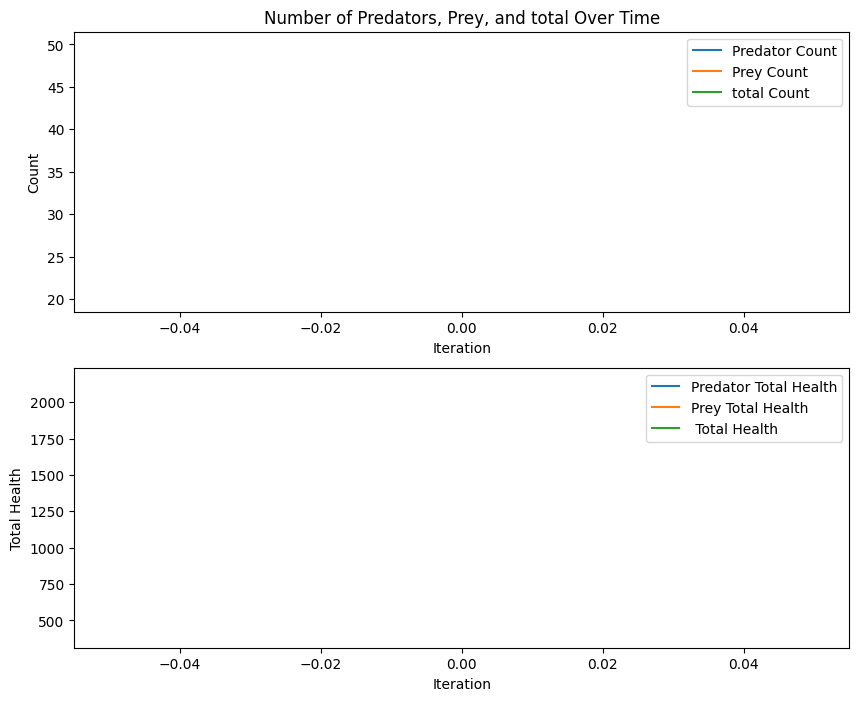

30	20


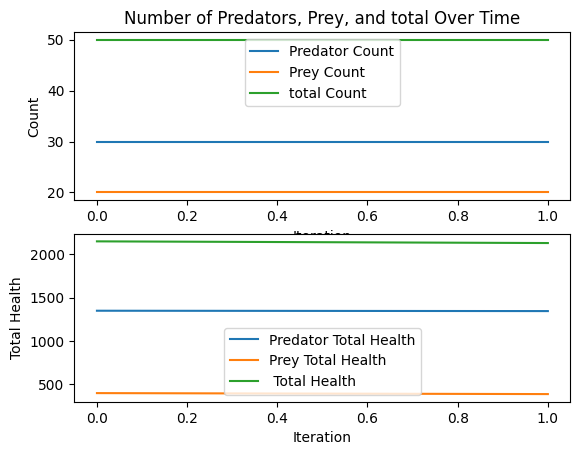

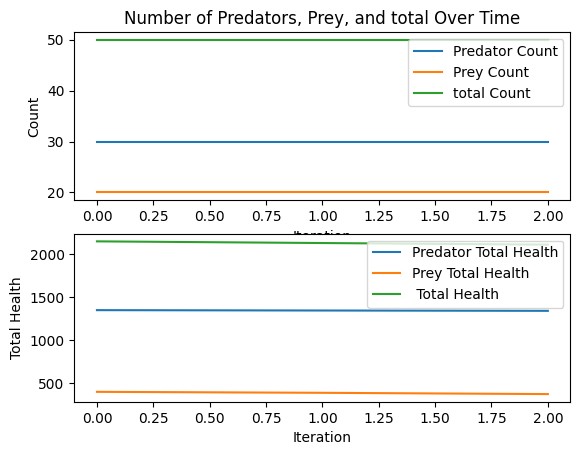

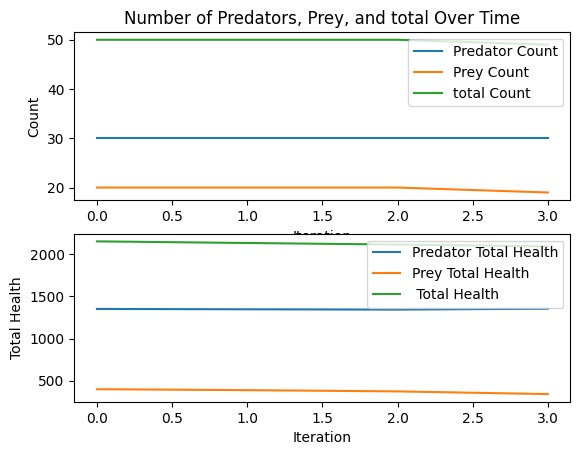

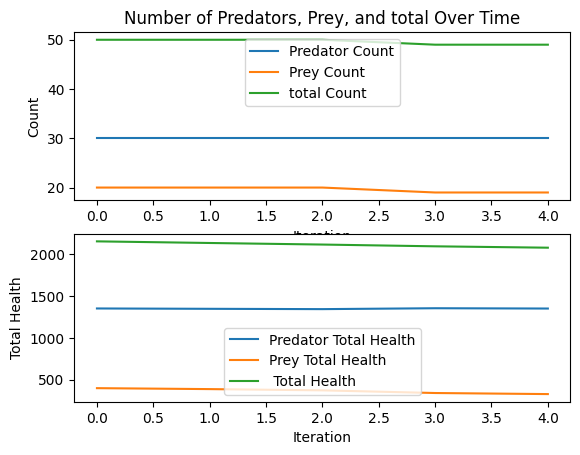

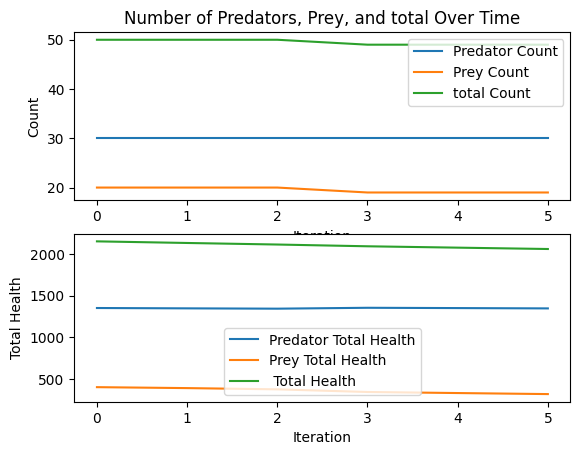

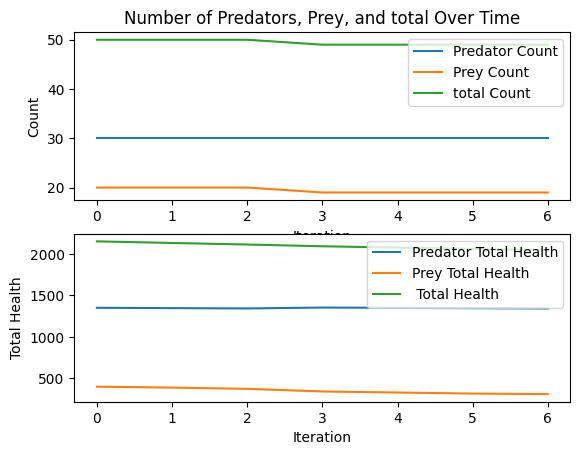

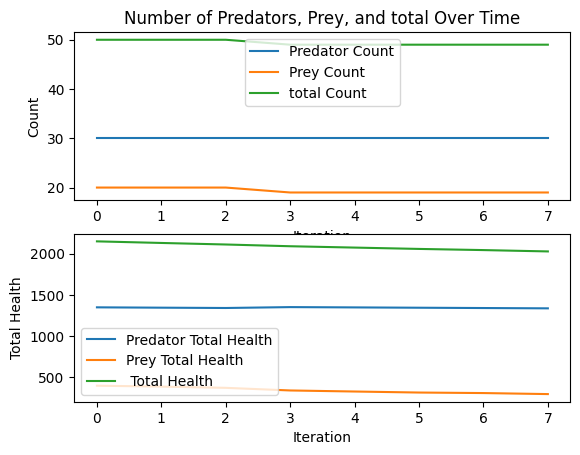

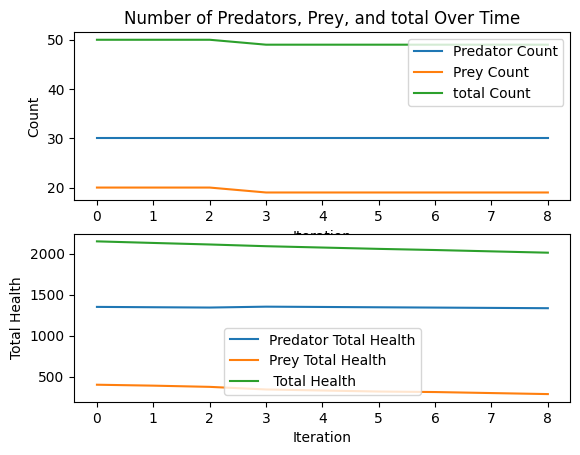

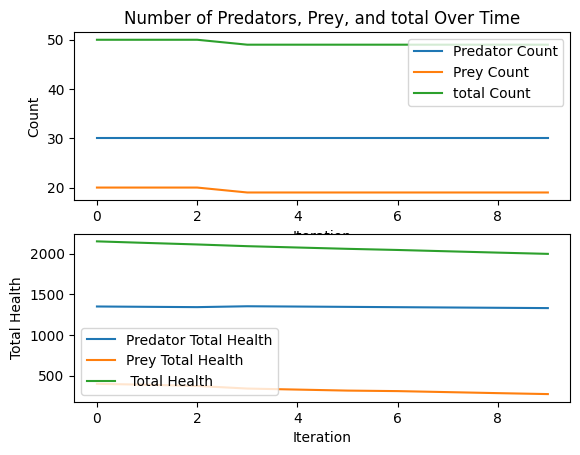

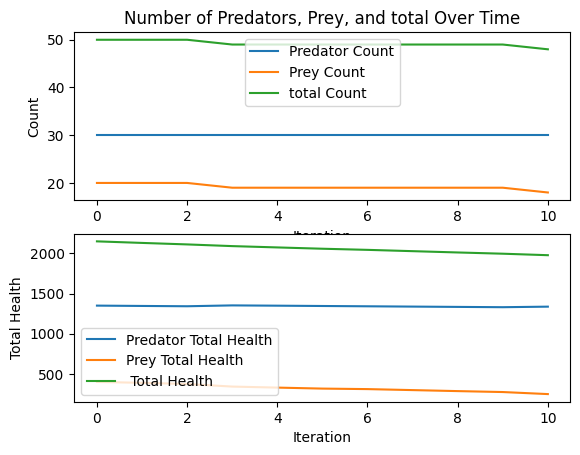

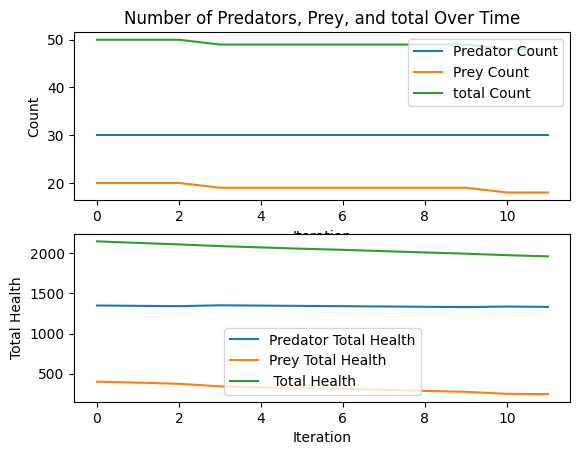

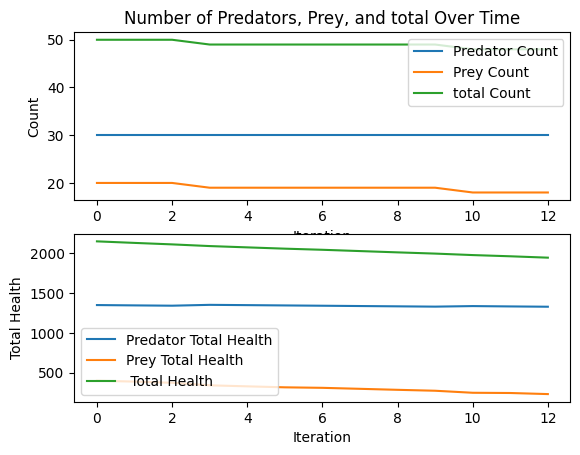

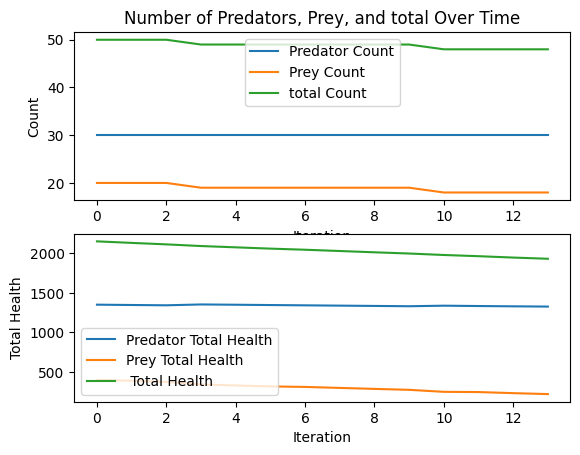

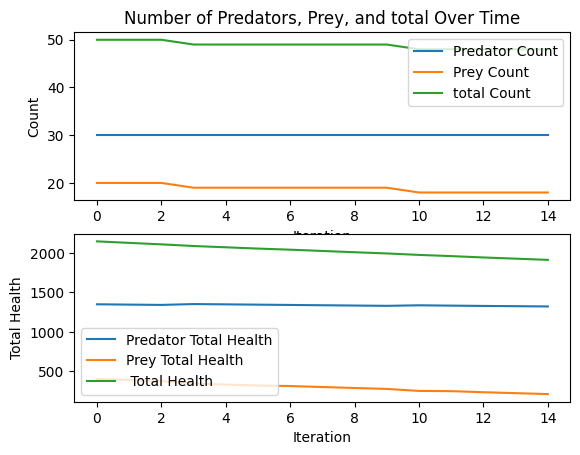

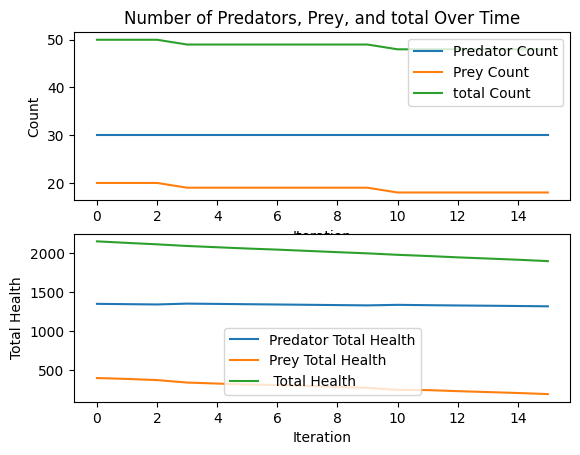

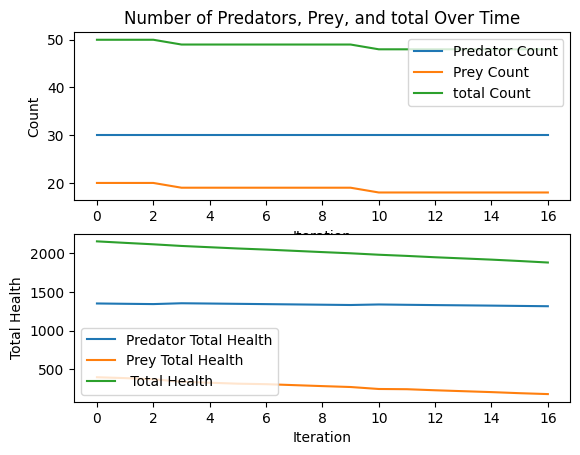

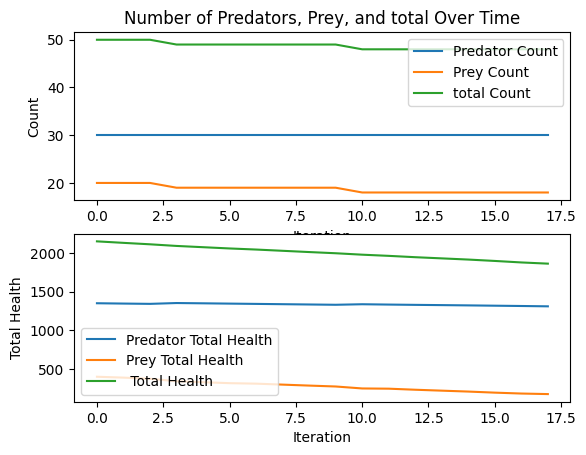

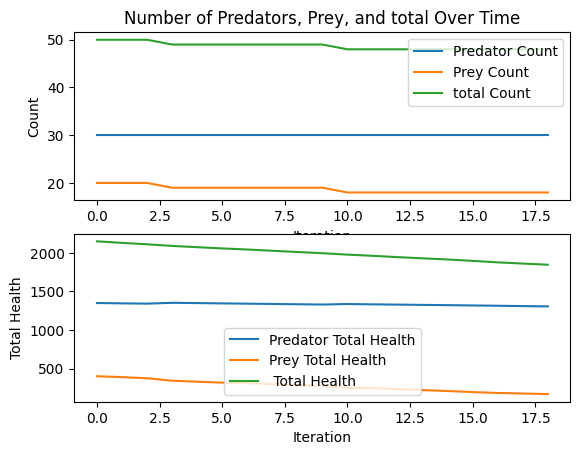

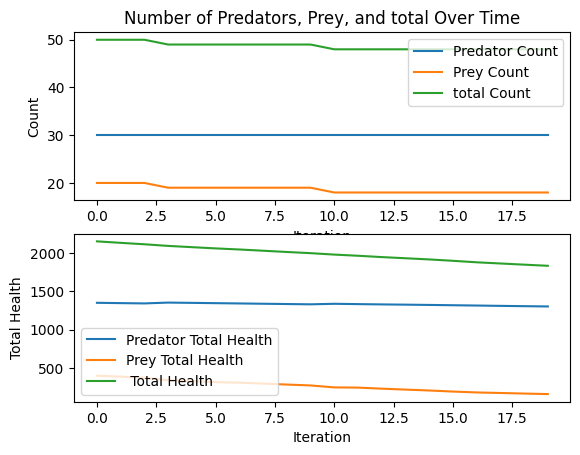

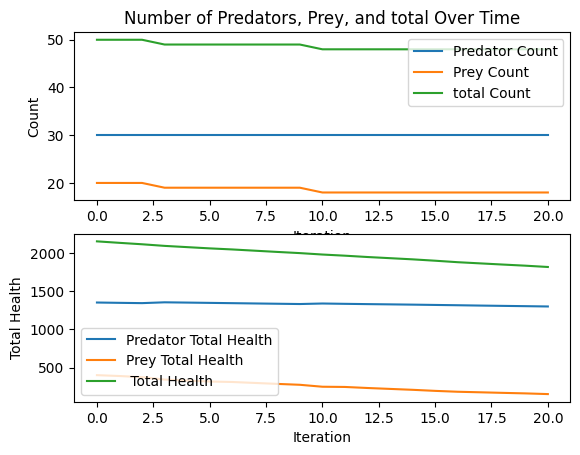

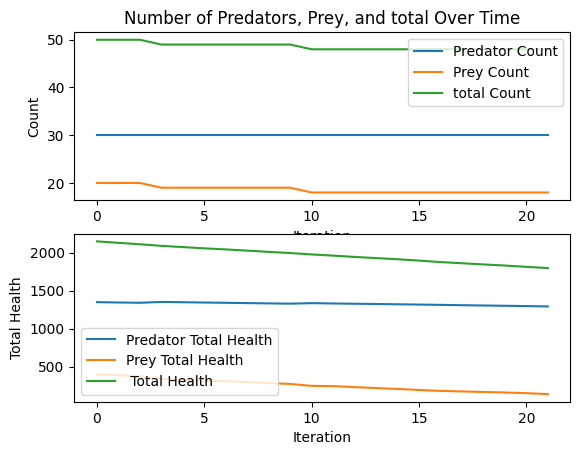

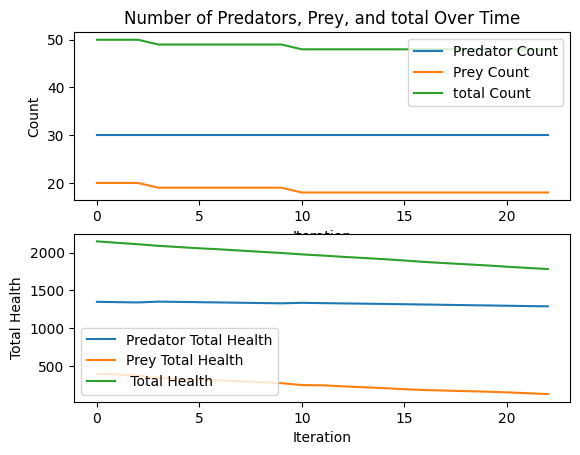

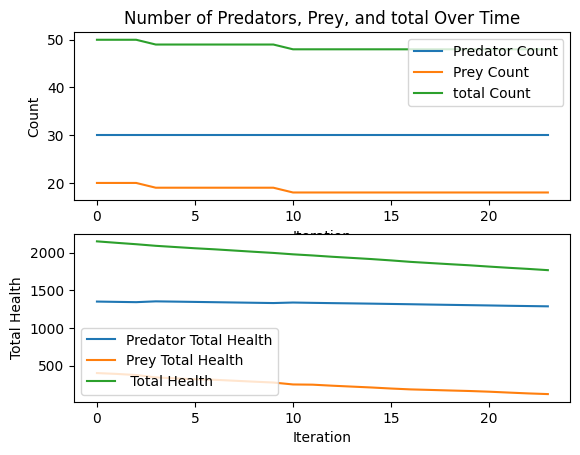

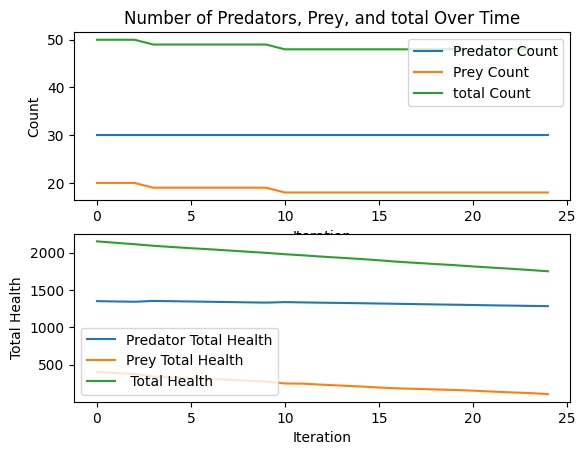

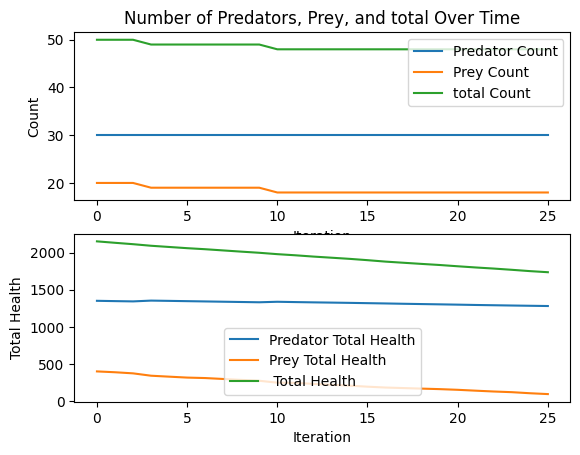

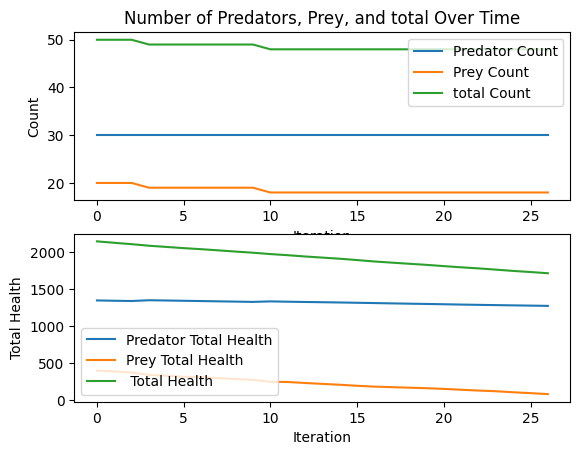

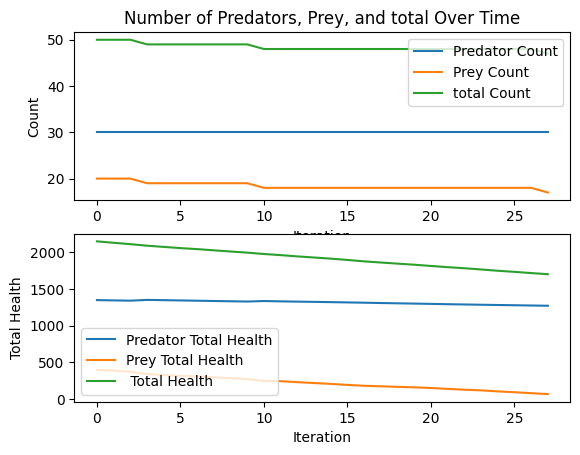

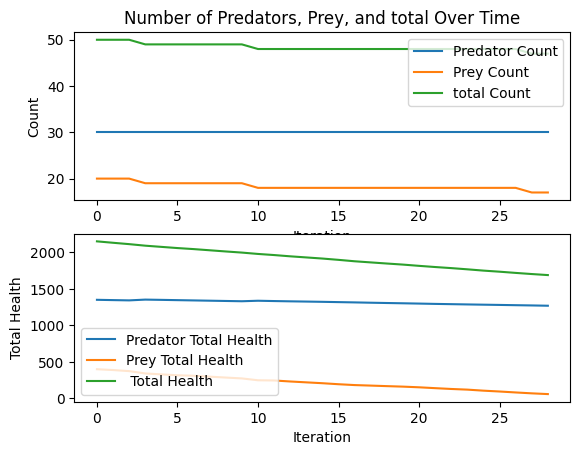

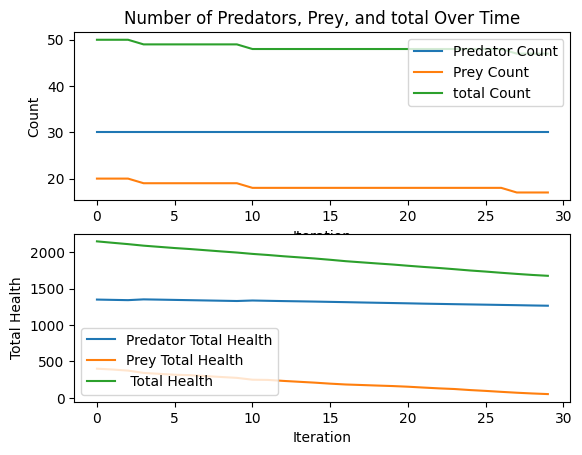

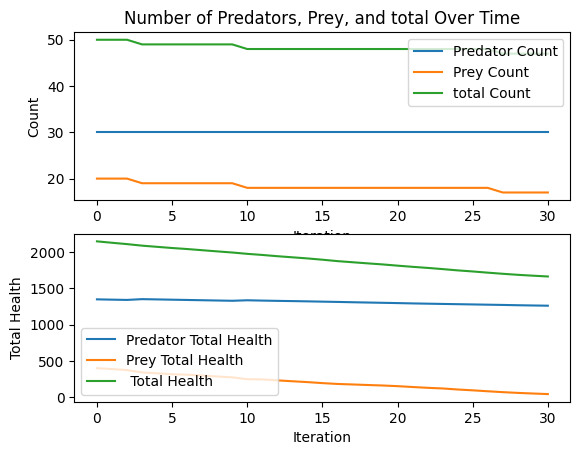

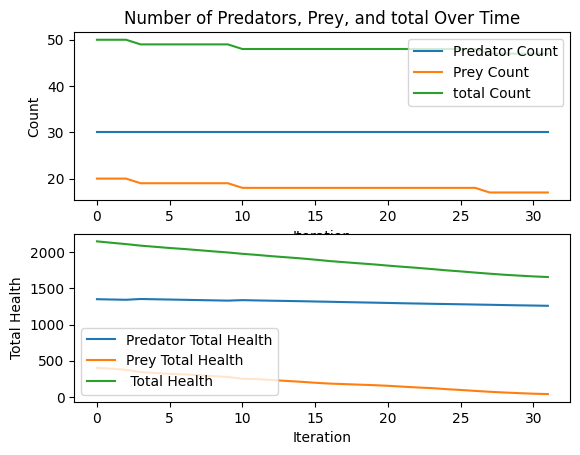

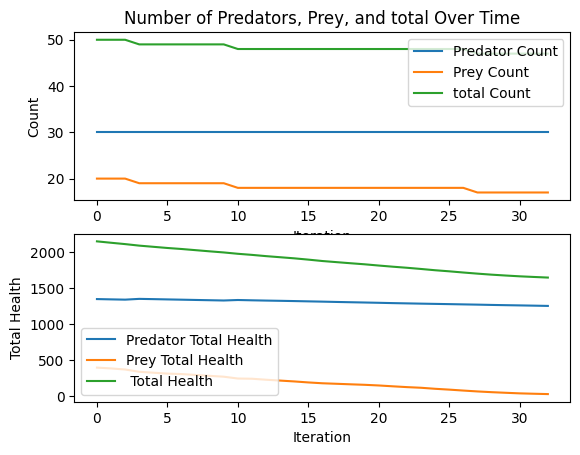

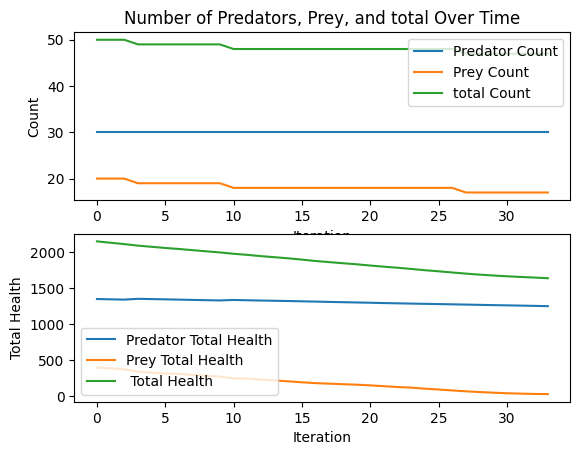

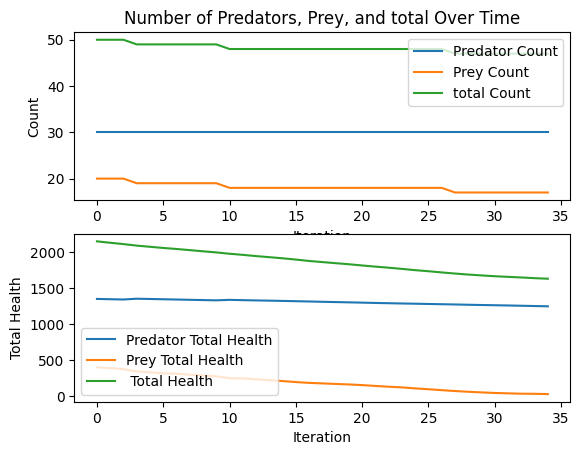

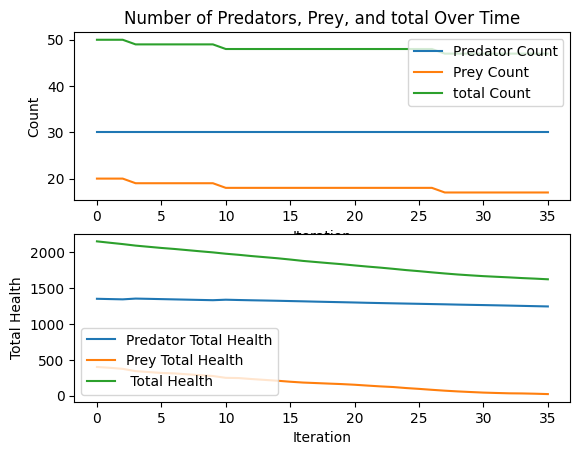

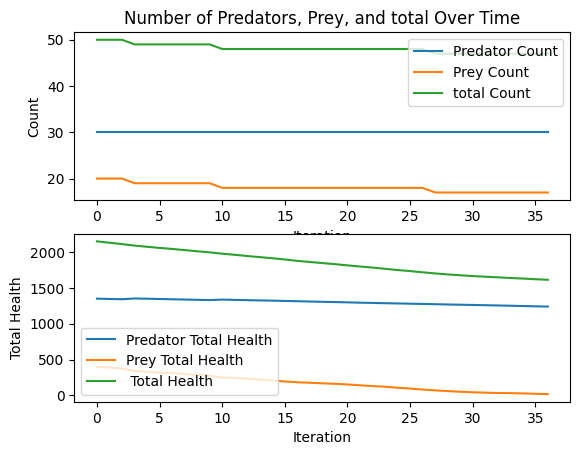

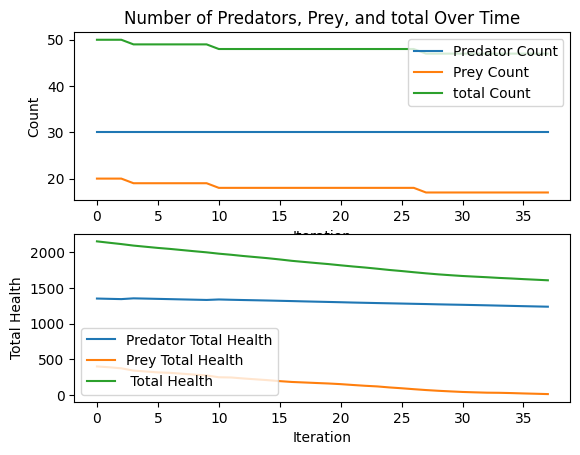

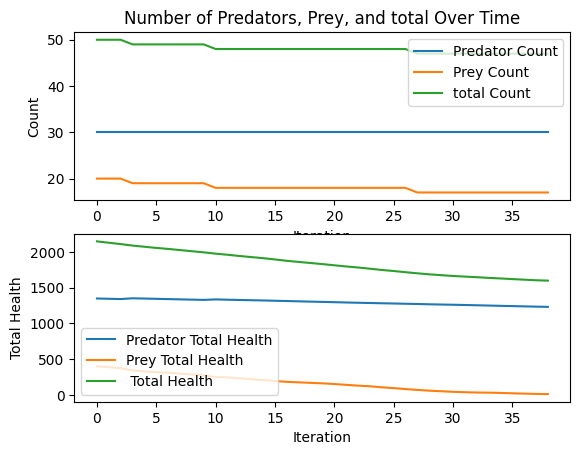

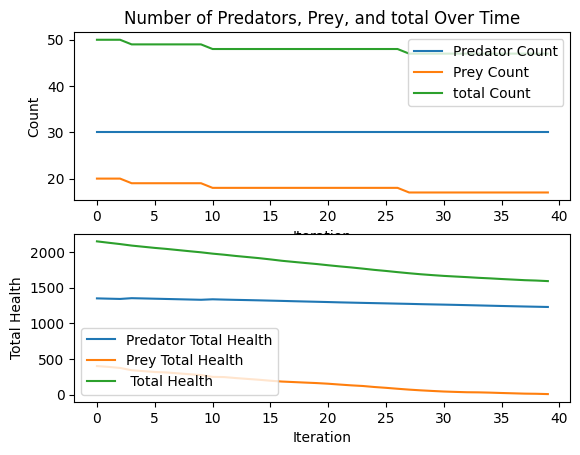

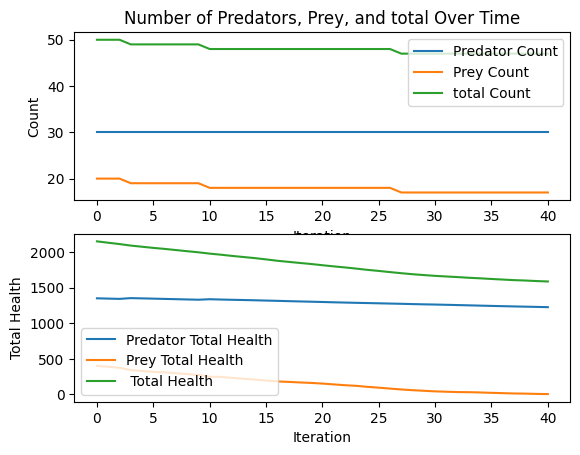

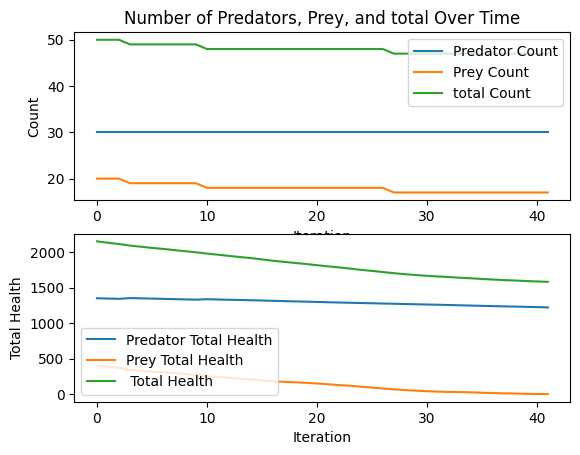

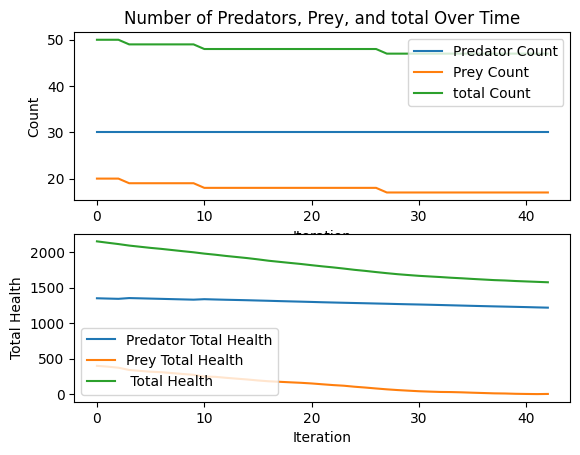

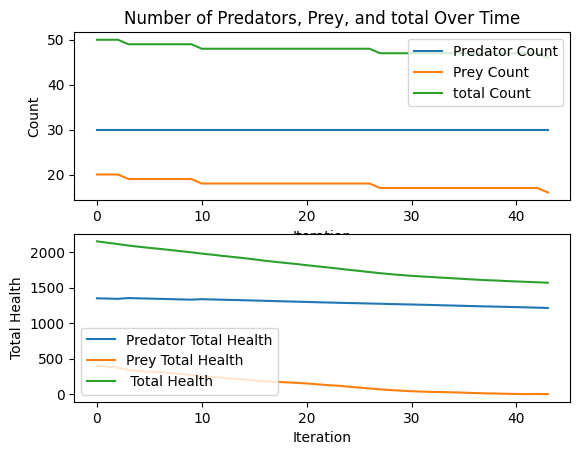

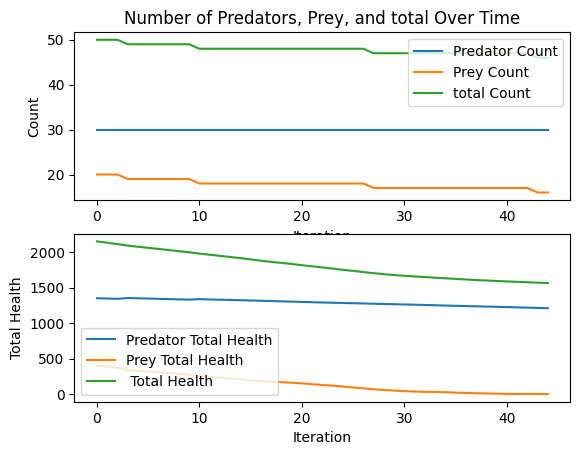

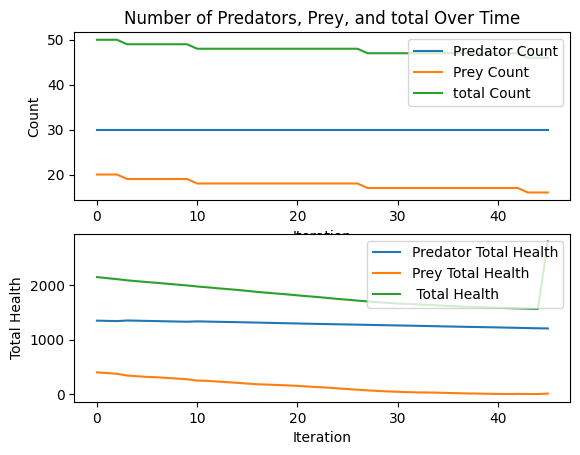

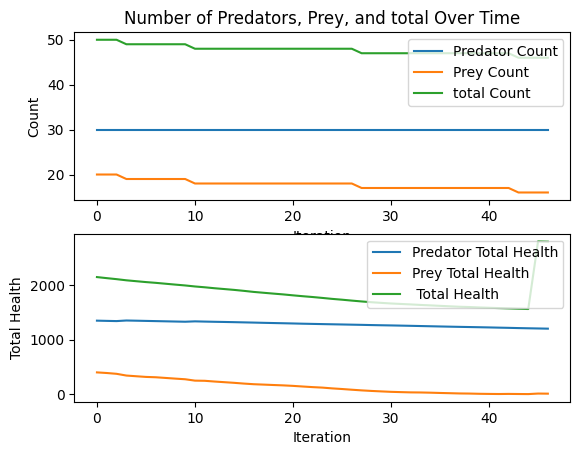

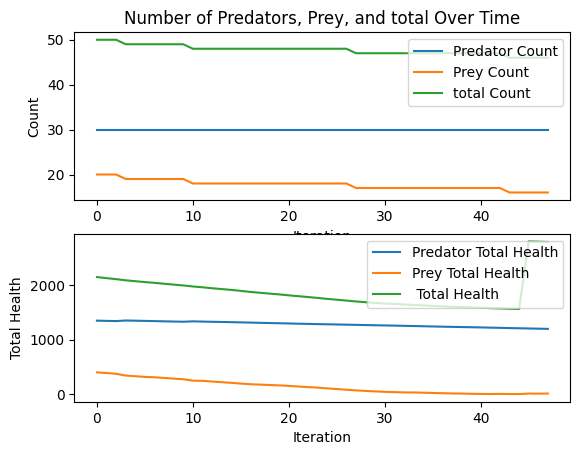

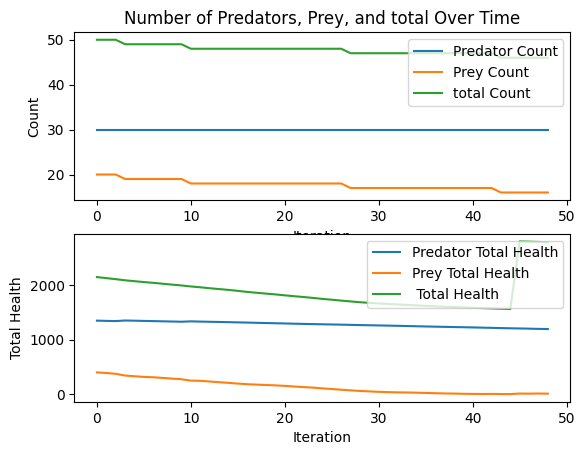

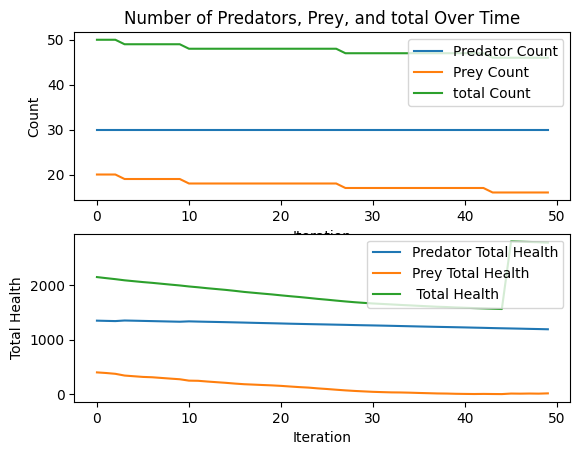

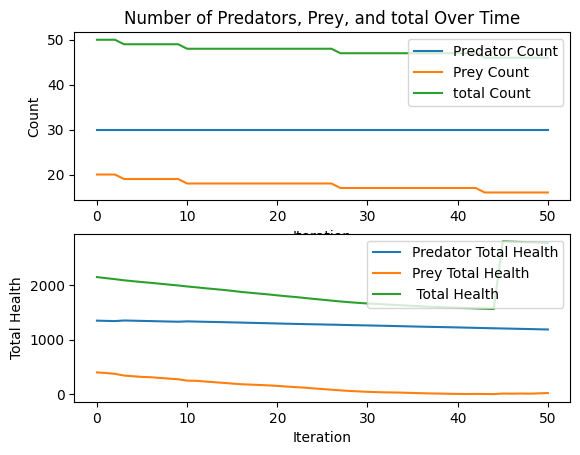

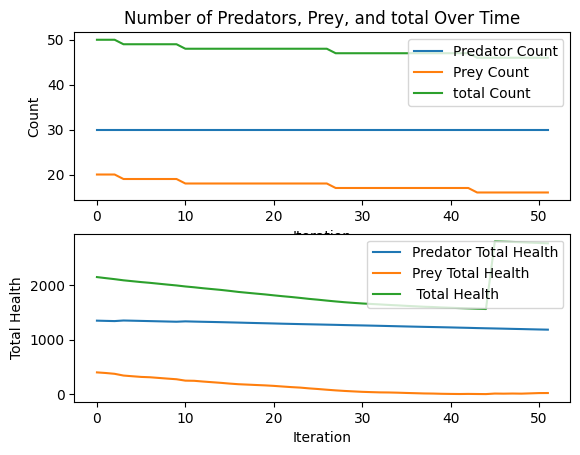

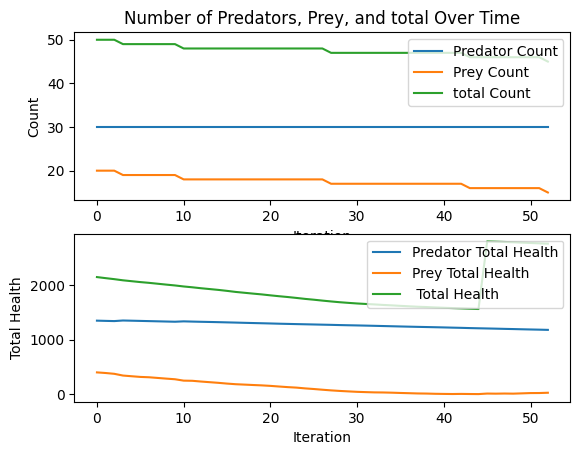

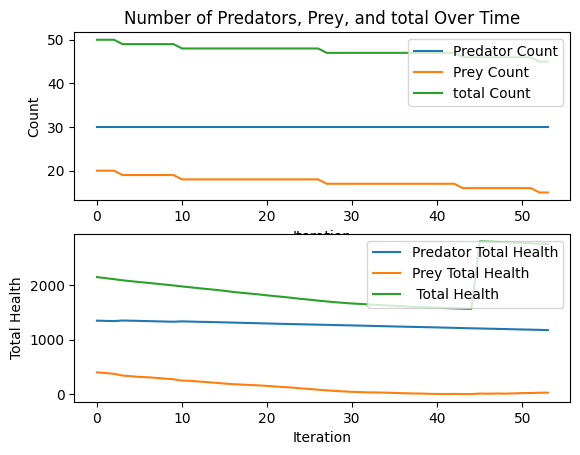

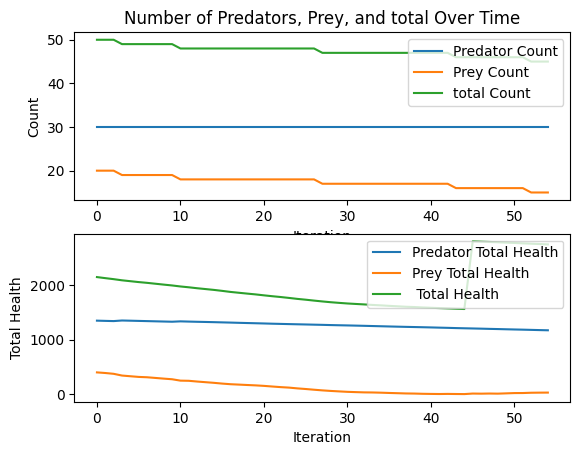

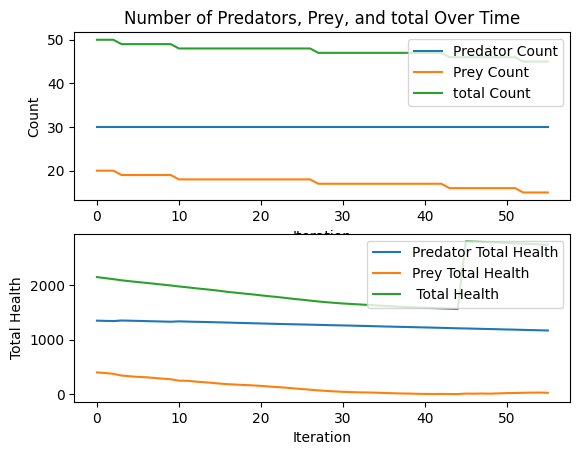

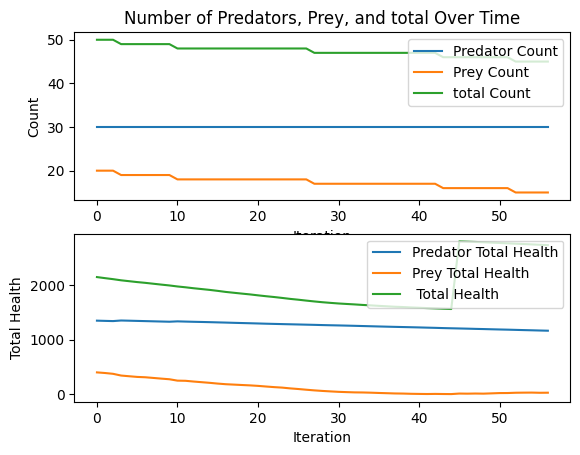

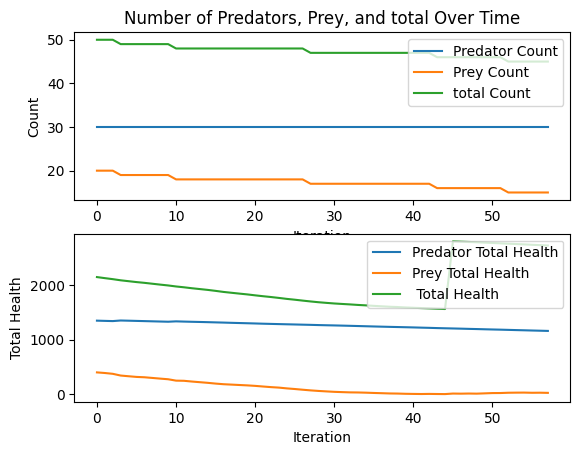

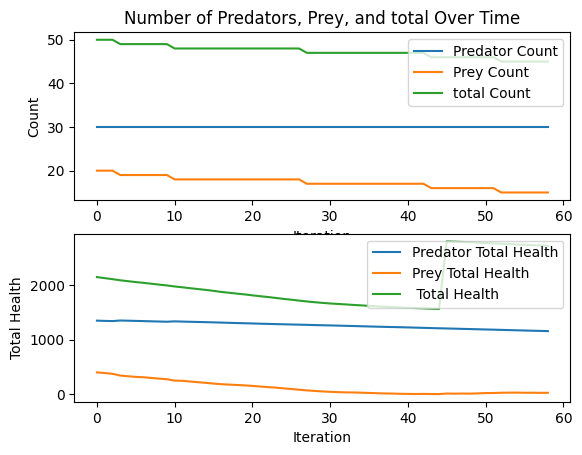

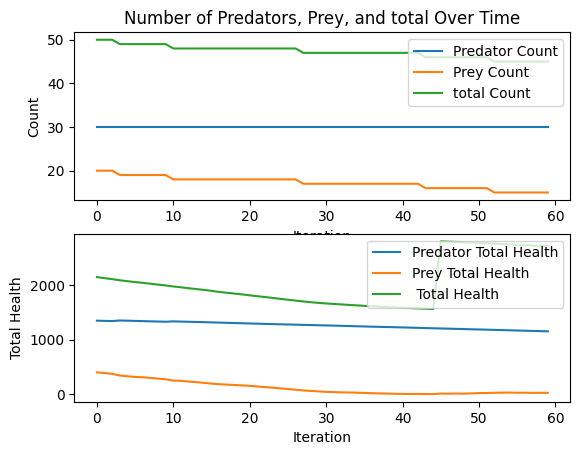

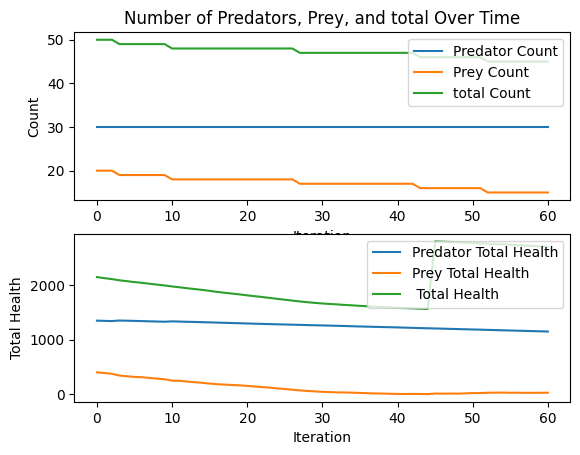

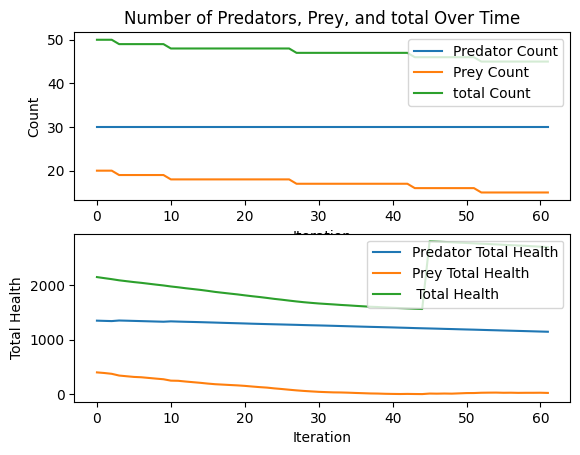

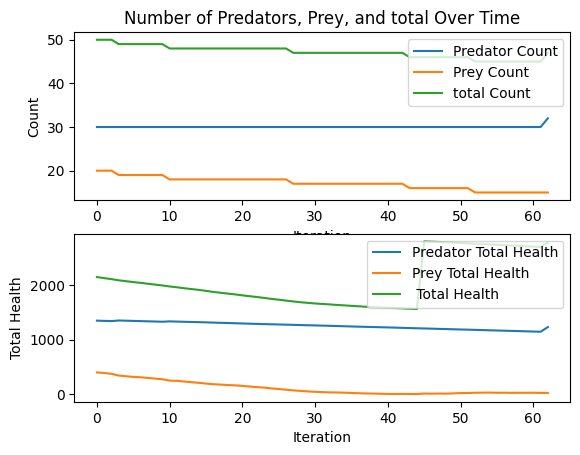

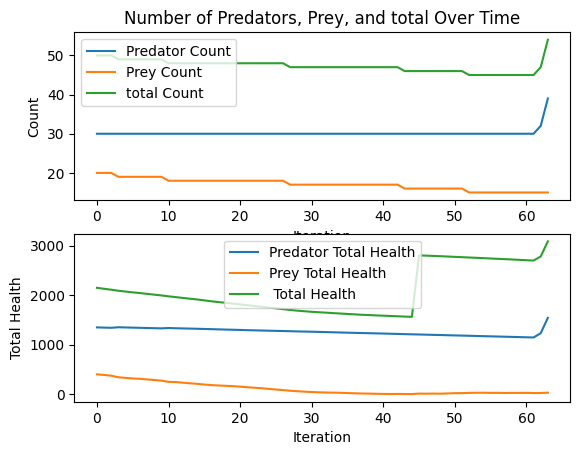

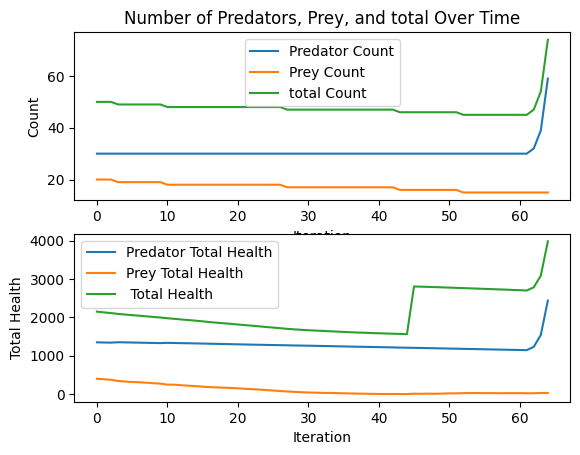

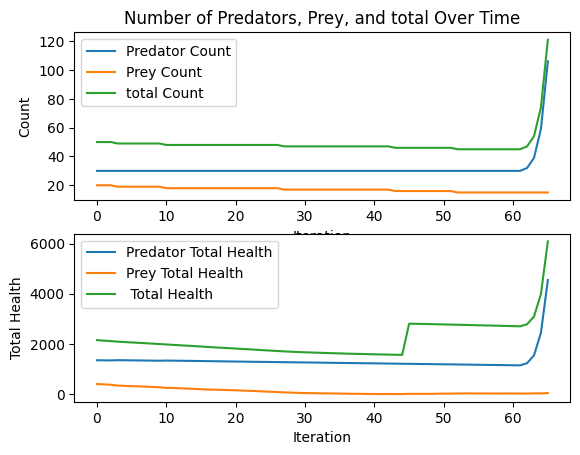

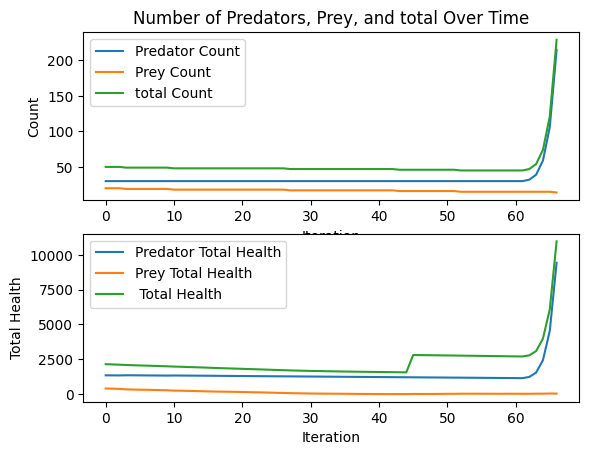

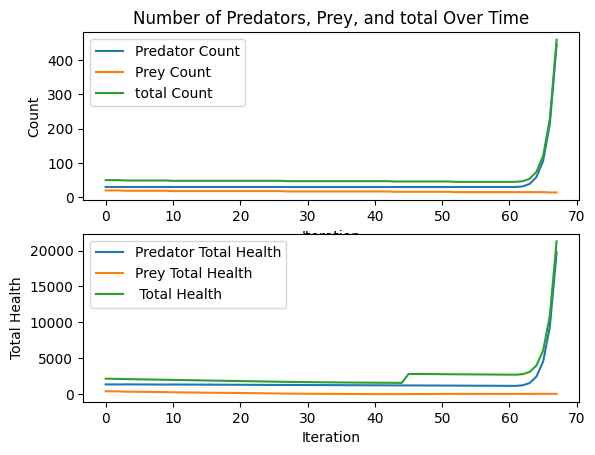

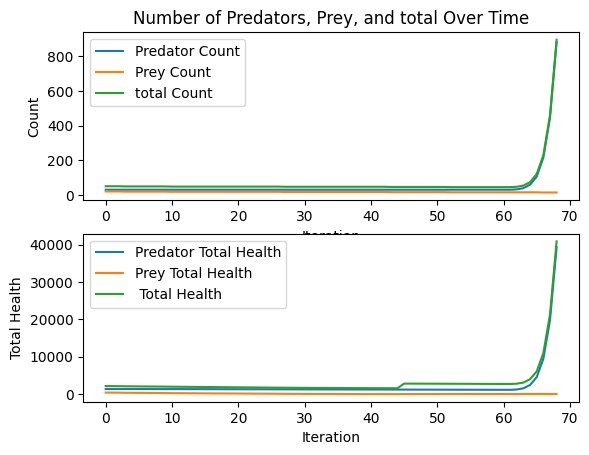

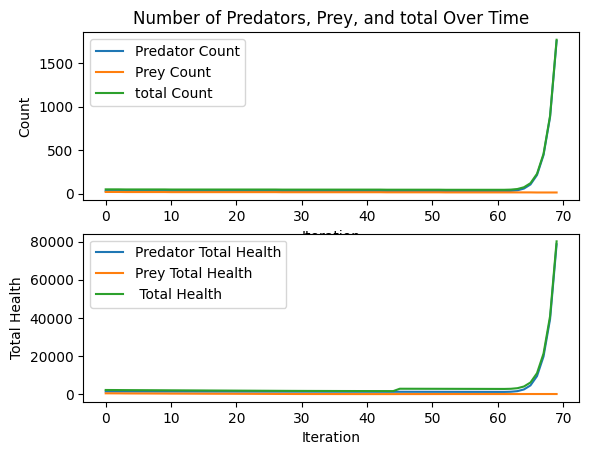

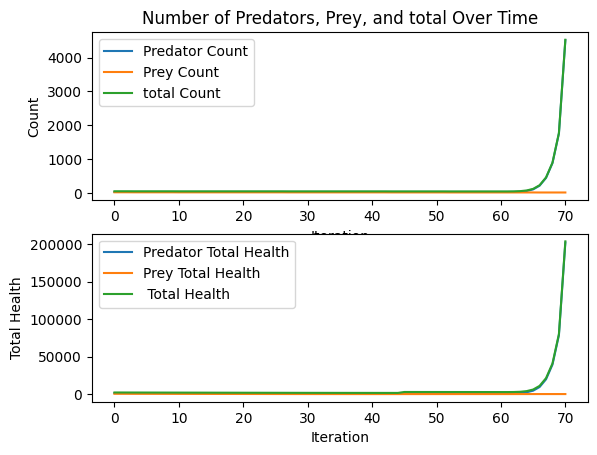

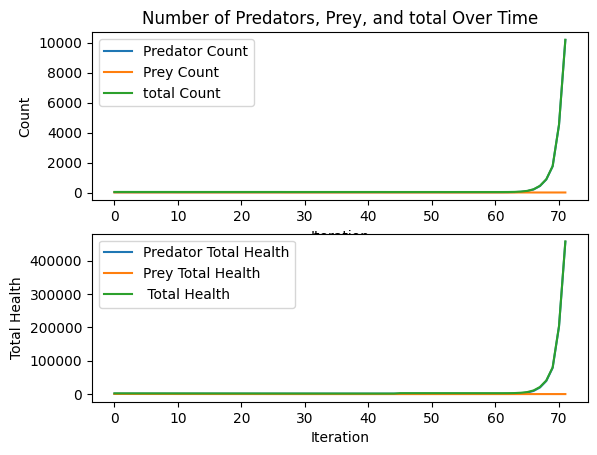

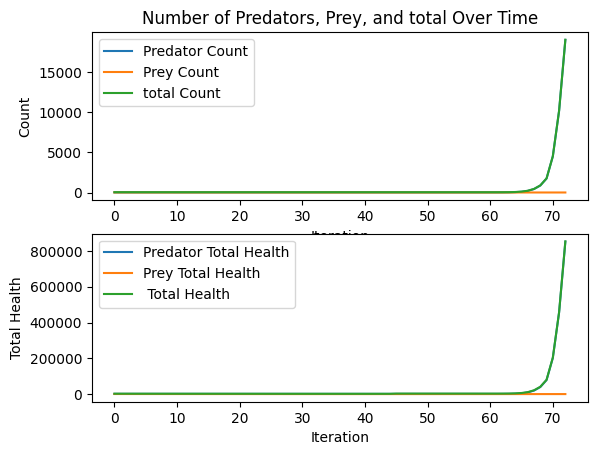

In [ ]:
if __name__ == "__main__":

    # register(
    #     id='LISPredatorPreyEnv-v0',
    #     entry_point='gym_env:LISPredatorPreyEnv',
    # )

    # env = gym.make('LISPredatorPreyEnv-v0')
    env = LISPredatorPreyEnv()
    env.pred_algorithms = ["PPO","PPO","PPO","PPO","DDPG","DDPG","DDPG"]
    env.pred_algorithms = ["PPO","PPO","PPO","DDPG","DDPG","DDPG"]
    # Define the algorithm functions
    def ppo_predator_algorithm(observation_info):
        angle = np.random.uniform(0, 2 * np.pi)

        # Generate random length less than A
        length = np.random.uniform(0, constants.PREY_MAX_SPEED)

        # Calculate x and y based on angle and length
        a = np.random.uniform(0, 1)
        x = length * np.cos(angle)
        y = length * np.sin(angle)

        velocity = np.array([a,x, y], dtype=np.float32)
        return velocity

    def dqn_predator_algorithm(observation_info):
        angle = np.random.uniform(0, 2 * np.pi)

        # Generate random length less than A
        length = np.random.uniform(0, constants.PREY_MAX_SPEED)

        # Calculate x and y based on angle and length
        a = np.random.uniform(0, 1)
        x = length * np.cos(angle)
        y = length * np.sin(angle)

        velocity = np.array([a,x, y], dtype=np.float32)
        return velocity

    def random_predator_algorithm(observation_info):
        angle = np.random.uniform(0, 2 * np.pi)

        # Generate random length less than A
        length = np.random.uniform(0, constants.PREY_MAX_SPEED)

        # Calculate x and y based on angle and length
        a = np.random.uniform(0, 1)
        x = length * np.cos(angle)
        y = length * np.sin(angle)

        velocity = np.array([a,x, y], dtype=np.float32)
        return velocity

    def ppo_prey_algorithm(observation_info):
        angle = np.random.uniform(0, 2 * np.pi)

        # Generate random length less than A
        length = np.random.uniform(0, constants.PREY_MAX_SPEED)

        # Calculate x and y based on angle and length
        a = np.random.uniform(0, 1)
        x = length * np.cos(angle)
        y = length * np.sin(angle)

        velocity = np.array([a,x, y], dtype=np.float32)
        return velocity

    def dqn_prey_algorithm(observation_info):
        angle = np.random.uniform(0, 2 * np.pi)

        # Generate random length less than A
        length = np.random.uniform(0, constants.PREY_MAX_SPEED)

        # Calculate x and y based on angle and length
        a = np.random.uniform(0, 1)
        x = length * np.cos(angle)
        y = length * np.sin(angle)

        velocity = np.array([a,x, y], dtype=np.float32)
        return velocity
    def random_prey_algorithm(observation_info):
        angle = np.random.uniform(0, 2 * np.pi)

        # Generate random length less than A
        length = np.random.uniform(0, constants.PREY_MAX_SPEED)

        # Calculate x and y based on angle and length
        a = np.random.uniform(0, 1)
        x = length * np.cos(angle)
        y = length * np.sin(angle)

        velocity = np.array([a,x, y], dtype=np.float32)
        return velocity

    # Create dictionaries to store algorithms
    env.simulator.predator_algorithms_predict = {
        "PPO": ppo_predator_algorithm,
        "DDPG": dqn_predator_algorithm,
        "random": random_predator_algorithm
    }

    env.simulator.prey_algorithms_predict = {
        "PPO": ppo_prey_algorithm,
        "DDPG": dqn_prey_algorithm,
        "random":random_prey_algorithm
    }

    # Master function to select and run the appropriate algorithm
    check_env(env)
    obs,info = env.reset()  # 重置环境并获取初始观测
    # print("Initial observation:", obs)
    # print(env.simulator.agent_status)

    for _ in range(10):  # 运行10个时间步
        # create initial agent algorithm 



        action = env.action_space.sample()  # 随机采样一个动作
        new_observations, rewards, terminated,truncated, infos = env.step(action)  # 采取一步行动
        len(env.simulator.predators)
        len(env.simulator.preys)
        len(env.simulator.foods)
        predator_total_health = sum(predator.health for predator in env.simulator.predators)
        prey_total_health = sum(prey.health for prey in env.simulator.preys)
        food_total_health = len(env.simulator.foods)* constants.FOOD_HEALTH_GAIN
        # print(f"Observation: {obs}, Reward: {rewards}, Done: {terminated}, Info: {infos}")
        print(f"Observation: {type(obs)}, Reward: {np.shape(rewards)}, Done: {np.shape(terminated)}, Info: {np.shape(infos)}")

        # print(np.shape(obs))
        if terminated:
            obs,info = env.reset()  # 如果环境结束了，则重置环境
    
    # check_env(env.unwrapped)
    check_env(env)

    run_random_simulation(env)
